# Analyis
## New Functionality

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, measure
)
import math
from scipy import signal
from skimage.filters import threshold_multiotsu, threshold_otsu, threshold_li
from glob import glob
import shutil
import os
import re
import warnings
import pandas as pd
from matplotlib.ticker import StrMethodFormatter
from scipy.stats import gaussian_kde
from scipy.stats.stats import spearmanr
from skimage.morphology import disk
from skimage.measure import label, regionprops, regionprops_table
from scipy import ndimage
from pathlib import Path
from skimage.segmentation import watershed, clear_border
warnings.filterwarnings('ignore')

In [2]:
def slice(im3d, savefig = False):
    #TODO rename to slicer
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    if savefig is True:
        plt.savefig('slice_overview.png')
    return chosen

In [3]:
def slice_center_mass(im3d, savefig = False):
    #TODO rename to slicer
    chosen = []
    centre_of_mass = ndimage.center_of_mass(im3d)
    com = centre_of_mass[0]
    if com % 1 <= 0.5:
        centre = math.floor(com)
        start = centre - 5
        stop = centre + 5
        for i in range(start, stop+1):
            chosen.append(i)
    else:
        centre = math.ceil(com)
        start = centre - 5
        stop = centre + 5
        for i in range(start, stop+1):
            chosen.append(i)
    #if savefig is True:
        #plt.savefig('slice_overview.png')
    return chosen

In [4]:
#TODO different slicing strategies

In [5]:
def display(im3d, cmap="gray", step=1, chosen = None, savefig = False):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    if savefig is True:
        plt.savefig('slice_gallery.png')

In [6]:
#TODO make saving conditional

In [7]:
def slice_manual(im3d,start,stop, savefig = False):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop+1)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    if savefig is True:
        plt.savefig('slice_overview.png')
    return chosen
    

In [8]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [9]:
#TODO channel chooser

F-ara-EdU = channel 3, Hoechst = channel 4

In [10]:
pixel_size = (28.3620)
#this is the number of pixels per micron, change the pixel size according to your specific image. You can find this out by clicking show info for the image in Fiji
scaling_factor = pixel_size**2

def slice_folder(inpath,channel,save_path,save_slice=True):
    path = os.walk(inpath)
    all_dataframes = []
    #print(f"rep:{Path(inpath).stem}")
    #print(f"cond: {Path(inpath).parent.stem}")
    for root, directories, files in path:
        for directory in directories:
            #print(directory)
            #print(os.path.join(root,directory))
            os.chdir(os.path.join(root,directory))
            subfiles = glob('*registered.tif', recursive=True)
            #print(subfiles)
            # cycles through default colors
            #plot0 = plt.plot(0,0)
            #cond0_color = plot0[0].get_color()   
            for file in subfiles:
                data = io.imread(os.path.join(root,directory,file))
                channel_data = data[:,:,:,channel-1]
                os.chdir(os.path.join(root,directory))
                chosen = slice_center_mass(channel_data, savefig = True)
                if (save_slice is True):
                    display(channel_data, chosen=chosen, savefig = True)
                #print(os.path.join(root,directory,file))
                print(file)
                print(chosen)
                all_coeff = []
                all_pvalue = []
                all_slice = []
                all_area = []
                if not os.path.exists(os.path.join(root,directory,"slices")):
                    os.mkdir(os.path.join(root,directory,"slices"))
                for slicing in chosen:
                    if not os.path.exists(os.path.join(root,directory,"slices", str(slicing))):
                        os.mkdir(os.path.join(root,directory,"slices", str(slicing)))
                    os.chdir(os.path.join(root,directory,"slices", str(slicing)))
                    filestring = file[:-4] + "_slice_" + str(slicing) + ".tif"
                    filestring_mask = file[:-4] + "_maskotsu_" + str(slicing) + ".tif"
                    #print(filestring)
                    #TODO: Make the channels choosable
                    data_edu = data[slicing,:,:,2]
                    data_hoechst = data[slicing,:,:,3]
                    # The input image.
                    image = data_hoechst

                    #otsu thresholding to generate binary mask
                    thresh = threshold_otsu(image)
                    #generate mask
                    mask = image > thresh


                    #Clear borders, get rid of cells which touch the edge of the image
                    cleared = clear_border(mask)

                    #get rid of the edge cases in the regions of interest, exclude things which are in regions but not in the cleared mask
                    #cleared_regions = np.logical_and(regions, cleared)
                    
                    #remove debris and other small objects below a certain size e.g. micronuclei
                    remove_debris = morphology.remove_small_objects(cleared, 3000)
                    
                    #set labels 
                    labels = measure.label(remove_debris)
                    #Measure properties
                    #set properties
                    props = measure.regionprops(labels)
                                                          
                    #create the csv data:
                    flat_edu = data_edu.flatten()
                    flat_hoechst = data_hoechst.flatten()
                    flat_cleared_remove_debris = remove_debris.flatten()
                    all_data = pd.DataFrame(zip(flat_edu,flat_hoechst, flat_cleared_remove_debris),columns=["edu","hoechst", "cleared"])
                    print(all_data)

                    #filter relevant data into new dataframe. Only values which are in cleared and also in regions chosen.

                    regions_filtered_data = all_data[all_data["cleared"] == True]
                    
                    #calculate area of nucleus, convert back to pixels, as a quality control for the thresholding, if the area is super low then the main mask touches the edge and was cleared in the clear borders step
                    cleared_area = 0
                    for i in range(len(props)):
                        #print((props[i].area))
                        cleared_area += props[i].area
                        nuclear_area = cleared_area/scaling_factor    
                        
                    #perform correlation
                    correlation_coeff, pvalue = spearmanr(regions_filtered_data["hoechst"], regions_filtered_data["edu"])
                    all_coeff.append(correlation_coeff)
                    all_pvalue.append(pvalue) 
                    all_slice.append(slicing)
                    all_area.append(nuclear_area)
                    #print(correlation_coeff)
                    if (save_slice is True):
                        io.imsave(filestring,data[slicing,:,:,:])
                        io.imsave(filestring_mask,remove_debris[:,:])
                single_df = pd.DataFrame(list(zip(all_coeff,all_pvalue,all_slice, all_area)),columns=["correlation_coeff", "pvalue", "slice", "area"])
                single_df['image'] = file
                single_df =  single_df[['image', 'area', 'slice', 'correlation_coeff', 'pvalue']]
                all_dataframes.append(single_df)
    final_df = pd.concat(all_dataframes)
    mean = final_df.groupby(['image'], as_index=False)[['area', 'correlation_coeff']].mean()
    #final_df = final_df.loc[['image', 'mean_scc']]
    #calculate_mean_df = pd.DataFrame(mean)
    if save_path is not None:
        print("SAVED")
        replicate = Path(inpath).stem
        cond = Path(inpath).parent.stem
        #final_df.csv(f'{save_path}/{cond}_{replicate}slices.csv', index = False)
        mean.to_csv(f'{save_path}/{cond}_{replicate}.csv', index=False)
    plt.close("all")
##TODO fix file keyword

In [11]:
#if slicing doesn't give the expected result, then you can manually slice the cells using this function, by inputting an inpath, a channel to slice, and start and stop slices
def slice_image(inpath,savepath, channel,start,stop):
    print(inpath)
    path = inpath
    os.chdir(path)
    file = glob('*registered.tif', recursive=True)[0]
    data = io.imread(os.path.join(path,file))
    channel_data = data[:,:,:,channel-1]
    chosen = slice_manual(channel_data, start, stop, savefig = True)
    display(channel_data, chosen=chosen, savefig = True)
    all_coeff = []
    all_pvalue = []
    all_slice = []
    if os.path.exists(os.path.join(path,"mslices")):
        shutil.rmtree(os.path.join(path,"mslices"))
    if not os.path.exists(os.path.join(path,"mslices")):
        os.mkdir(os.path.join(path,"mslices"))
    for slicing in chosen:
        if not os.path.exists(os.path.join(path,"mslices", str(slicing))):
            os.mkdir(os.path.join(path,"mslices", str(slicing)))
        os.chdir(os.path.join(path,"mslices", str(slicing)))
        filestring = file[:-4] + "_slice_" + str(slicing) + ".tif"
        io.imsave(filestring,data[slicing,:,:,:])
        data_edu = data[slicing,:,:,2]
        data_hoechst = data[slicing,:,:,3]
        # The input image.
        image = data_hoechst

        thresh = threshold_li(image)
        #remove small holes by performing closing. Binary_closing faster for binary images.
        binary_mask = morphology.binary_closing(image > thresh, disk(5))

        #remove edge artefacts with cleared
        #cleared = segmentation.clear_border(binary_mask)

        #erode binary mask with disk size of 20
        eroded = morphology.erosion(binary_mask, disk(20))

        #crerate the csv data:
        flat_edu = data_edu.flatten()
        flat_hoechst = data_hoechst.flatten()
        flat_eroded = eroded.flatten()
        all_data = pd.DataFrame(zip(flat_edu,flat_hoechst,flat_eroded),columns=["edu","hoechst","eroded"])
        #filter relevant data
        regions_filtered_data = all_data.loc[all_data.eroded == True]
        #perform correlation
        correlation_coeff, pvalue = spearmanr(regions_filtered_data["hoechst"], regions_filtered_data["edu"])
        all_coeff.append(correlation_coeff)
        all_pvalue.append(pvalue) 
        all_slice.append(slicing)
        #print(correlation_coeff)
        #if (save_slice is True):
            #io.imsave(filestring,data[slicing,:,:,:])
    single_df = pd.DataFrame(list(zip(all_coeff,all_pvalue,all_slice)),columns=["correlation_coeff", "pvalue", "slice"])
    single_df['image'] = file
    single_df =  single_df[['image', 'slice', 'correlation_coeff', 'pvalue']]
    #all_dataframes.append(single_df)
    #final_df = pd.concat(all_dataframes)
    if savepath is not None:
        print("SAVED")
        #replicate = Path(inpath).stem
        #cond = Path(inpath).parent.stem
        single_df.to_csv(f'{savepath}/{file}.csv', index = False)
    plt.close("all")
        

The manual slice_image will create a folder mslice instead to show that these were taken manually. Rerunning with different parameters will remove the previous content of the mslice folder.

# Apply to the full dataset

In [13]:
base_path = "/groups/gerlich/members/PaulBatty/Paper_preparation/slicer_com/tifs_registered_background_subtracted_testing/wt_prometa/"
conditions = next(os.walk(base_path))[1]
#remove hidden folder created by jupyter:
clean_conditions = [c for c in conditions if not re.match(r'^\.', c)]
conditions = sorted(clean_conditions)
conditions

['wt_prometa_one_sister',
 'wt_prometa_two_sister',
 'wt_prophase_early_one_sister',
 'wt_prophase_late_one_sister',
 'wt_prophase_mid_one_sister',
 'wt_prophase_nebd_one_sister',
 'wt_prophase_two_sister']

In [14]:
wt = [c for c in conditions if re.match(r'wt', c)]

CONDITION: wt_prometa_one_sister
REPLICATES: ['5003', '5325', '5389', '5487', '5517']
/groups/gerlich/members/PaulBatty/Paper_preparation/slicer_com/tifs_registered_background_subtracted_testing/wt_prometa/wt_prometa_one_sister/5003
5003_WT_20min_hemi_5_meta_rep2_zoom-01-99.czi #5.tif_registered.tif
[43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]
        edu  hoechst  cleared
0         0        6    False
1         0        4    False
2         0        2    False
3         0        0    False
4         0        0    False
...     ...      ...      ...
547595    0        0    False
547596    0        0    False
547597    0        0    False
547598    0        0    False
547599    0        0    False

[547600 rows x 3 columns]
        edu  hoechst  cleared
0         0        0    False
1         0        1    False
2         0        0    False
3         0        0    False
4         0        0    False
...     ...      ...      ...
547595    0        0    False
547596    0        0    Fal

KeyboardInterrupt: 

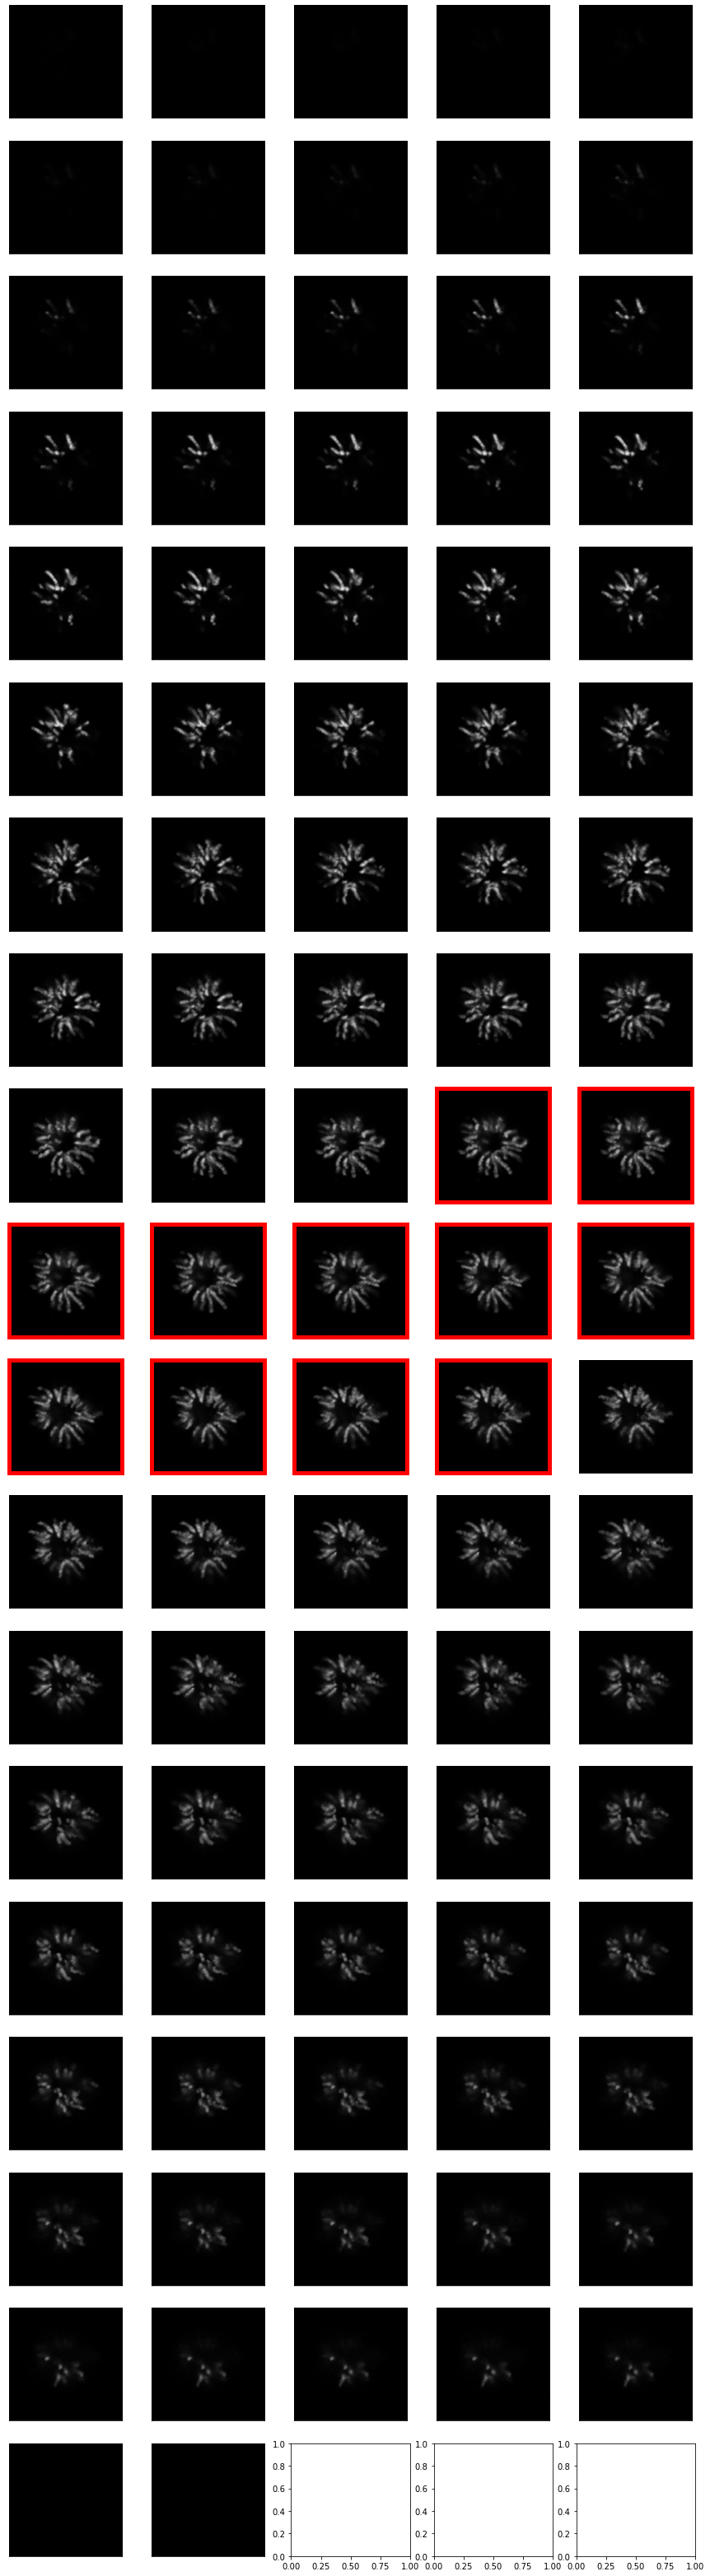

In [15]:
for condition in wt:
    replicates = next(os.walk(os.path.join(base_path,condition)))[1]
    clean_replicates = [c for c in replicates if not re.match(r'^\.', c)]
    replicates = sorted(clean_replicates)
    print(f'CONDITION: {condition}')
    print(f'REPLICATES: {replicates}')
    for replicate in replicates:
        folder_to_slice = os.path.join(base_path,condition,replicate)
        print(folder_to_slice)
        slice_folder(folder_to_slice, 3, "/groups/gerlich/members/PaulBatty/Paper_preparation/slicer_com/quantification/results/otsu_mid11_remove_debris/")      
        #pass
plt.close("all")